In [1]:
# by Joh Schoeneberg, 2018
# BSD 3-clause licence

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook



#import cv2
import pims
from PIL import Image

import skimage

import json

#pyLattice modules / functions
import pylattice
import pylattice.functions.InputProcessing as inproc
import pylattice.functions.TiffProcessing as tiffproc
import pylattice.classes.Track as Track

# read-in the data

In [9]:
path = '/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/'


filepath = path+'_inputParameters.csv'
print(filepath)
inputParameters = pd.read_csv(filepath,names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")


slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))

/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/_inputParameters.csv


In [15]:
# read the raw csv data for further processing

filepath = path+outputDataFolder+'/'+trackingCsvFilenameProcessed
print(filepath)


data = pd.read_csv(filepath,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

dataUnique = data.drop_duplicates(subset='trackId')

lengthTreshold = 5 #frames
trackIdsLong = (data[data['tracklength'] > lengthTreshold]).drop_duplicates(subset='trackId')['trackId'].values
longTracks = data[data['tracklength'] > lengthTreshold]
longTracks

print("total number of tracks: {}\nunique tracks: {}\nlongtracks (len>{}) {}".format(len(data),len(dataUnique),lengthTreshold,len(longTracks.drop_duplicates(subset='trackId'))))

/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/./output/trackedFeaturesProcessed.csv
total number of tracks: 1015
unique tracks: 205
longtracks (len>5) 75


# Create Track objects for every track

In [20]:
# create Track objects for every track

import timeit


trackIdListInvestigated = trackIdsLong
print(len(trackIdListInvestigated))

start_time = timeit.default_timer()

tracks = []
cm0 = []
len0 = []
Amean0 = []
maxDist0 = []



for i in range(0,len(trackIdListInvestigated)):
    if(i %1000 == 0):
        print(str(i)+"/"+str(len(trackIdListInvestigated)))
    trackData = data[data['trackId'] == trackIdListInvestigated[i]]
    #a = Track.Track(trackData,latticeMovieFrame_shape)
    a = Track.Track(trackData)
    tracks.append(a)
    cm0.append(a.m_cm)
    len0.append(a.len)
    Amean0.append(a.m_Amean)
    maxDist0.append(a.m_maxDist)
    
elapsed = timeit.default_timer() - start_time
print('time elapse: '+str(np.round(elapsed,decimals=2))+'s')

75
0/75
time elapse: 0.19s


Text(0.5,1,'Amplitude distribution in first frame of all tracks')

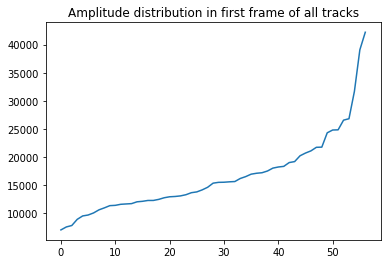

In [52]:
allFirstFrameCoordinates = []
allFirstFrameAmplitudes = []
allTracksThatStartOnFrame0 = []
index = 0
for track in tracks:
    if(track.frameId[0]==1):
#        if(track.A[0]>10000):
            allFirstFrameAmplitudes.append(track.m_A[0])
            allFirstFrameCoordinates.append(track.m_coords[0])
            allTracksThatStartOnFrame0.append(index)
    index = index+1
    
    
plt.plot(np.sort(allFirstFrameAmplitudes))
plt.title("Amplitude distribution in first frame of all tracks")

# example plotting of a track

In [22]:
tracks[16].plot()

NameError: name 'plt' is not defined

In [26]:
tracks[16].plot_xz()

NameError: name 'plt' is not defined

In [25]:
tracks[16].plot_yz()

NameError: name 'plt' is not defined

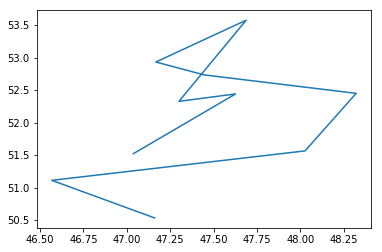

In [33]:
tracks[16].m_coords[0]
plt.plot(tracks[16].m_coords[:,0],tracks[16].m_coords[:,2])

# Plot tracks as 2D projections into max intensitz projection of the raw data

In [27]:
slave_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(path+inputDataFolder,slave_uniqueFilenameString)
master_filesOfInterest = inproc.getFilenamesOfInputTiffFiles(path+inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/./
--- example of files found: cropped_488_pm50px_maxAmpl_0000.tif
--- number of files found: 10
--- folder searched in: /Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/./
--- example of files found: cropped_560_pm50px_maxAmpl_0000.tif
--- number of files found: 10


/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/.//cropped_560_pm50px_maxAmpl_0000.tif
(100, 100, 100)


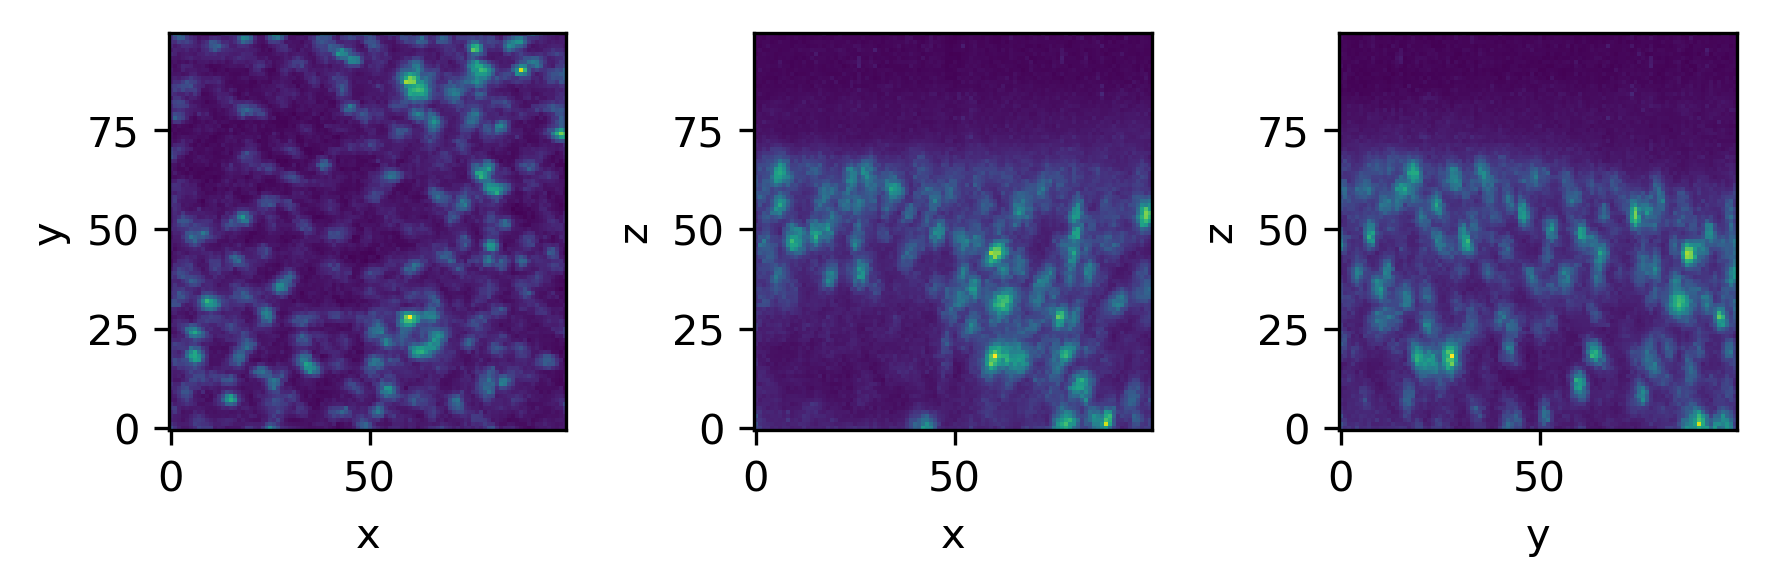

In [34]:
# read the image from where the detections come from
frameId = 0

filepath = path+inputDataFolder+'/'+master_filesOfInterest[frameId]
print(filepath)
latticeMovieFrame = skimage.external.tifffile.imread(filepath)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/.//cropped_560_pm50px_maxAmpl_0000.tif


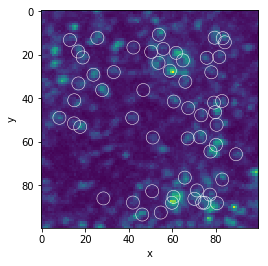

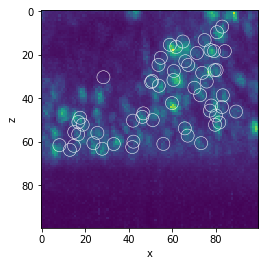

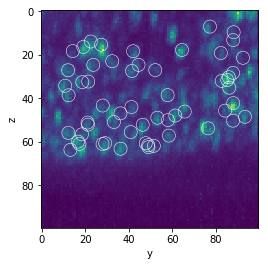

In [43]:
from matplotlib.patches import Circle


filepath = path+inputDataFolder+'/'+master_filesOfInterest[0]
print(filepath)
latticeMovieFrame = skimage.external.tifffile.imread(filepath)


fig,ax = plt.subplots(1)#,dpi=300)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=0))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((xx-1,yy-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=1))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((xx-1,np.abs(zz-100)-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
plt.xlabel('x')
plt.ylabel('z')
plt.show()


fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=2))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((yy-1,np.abs(zz-100)-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
plt.xlabel('y')
plt.ylabel('z')
plt.show()

/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/.//cropped_560_pm50px_maxAmpl_0000.tif


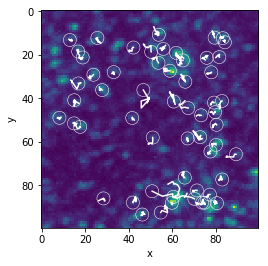

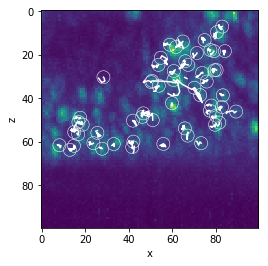

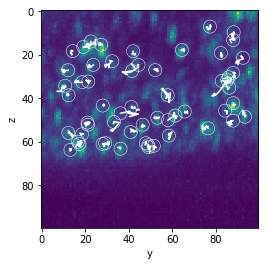

In [49]:
from matplotlib.patches import Circle

trDisplay = tracks[0]
trDisplayCoords = trDisplay.m_coords[0]

filepath = path+inputDataFolder+'/'+master_filesOfInterest[0]
print(filepath)
latticeMovieFrame = skimage.external.tifffile.imread(filepath)


fig,ax = plt.subplots(1)#,dpi=300)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=0))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((xx-1,yy-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
for trackId in allTracksThatStartOnFrame0:
    plt.plot(tracks[trackId].m_coords[:,0]-1,tracks[trackId].m_coords[:,1]-1,c='white')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=1))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((xx-1,np.abs(zz-100)-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
for trackId in allTracksThatStartOnFrame0:
    plt.plot(tracks[trackId].m_coords[:,0]-1,np.abs(tracks[trackId].m_coords[:,2]-100)-1,c='white')
plt.xlabel('x')
plt.ylabel('z')
plt.show()


fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=2))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((yy-1,np.abs(zz-100)-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
for trackId in allTracksThatStartOnFrame0:
    plt.plot(tracks[trackId].m_coords[:,1]-1,np.abs(tracks[trackId].m_coords[:,2]-100)-1,c='white')    
plt.xlabel('y')
plt.ylabel('z')
plt.show()

/Users/johannesschoeneberg/Dropbox/pylattice_testData/imaging_data/.//cropped_560_pm50px_maxAmpl_0000.tif


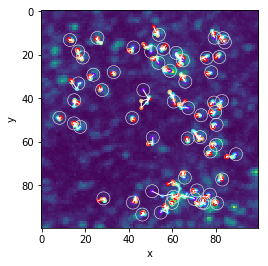

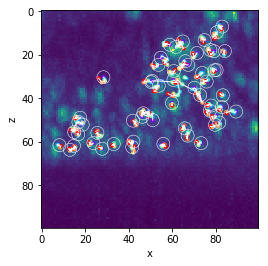

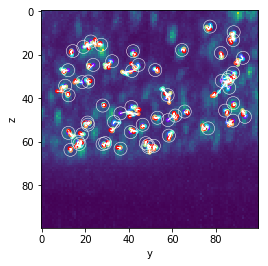

In [51]:
from matplotlib.patches import Circle

trDisplay = tracks[0]
trDisplayCoords = trDisplay.m_coords[0]

filepath = path+inputDataFolder+'/'+master_filesOfInterest[0]
print(filepath)
latticeMovieFrame = skimage.external.tifffile.imread(filepath)


fig,ax = plt.subplots(1)#,dpi=300)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=0))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((xx-1,yy-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
for trackId in allTracksThatStartOnFrame0:
    plt.plot(tracks[trackId].m_coords[:,0]-1,tracks[trackId].m_coords[:,1]-1,c='white',lw=1)
    plt.scatter(tracks[trackId].m_coords[:,0]-1,tracks[trackId].m_coords[:,1]-1,c=tracks[trackId].frameId,cmap='rainbow',s=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=1))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((xx-1,np.abs(zz-100)-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
for trackId in allTracksThatStartOnFrame0:
    plt.plot(tracks[trackId].m_coords[:,0]-1,np.abs(tracks[trackId].m_coords[:,2]-100)-1,c='white',lw=1)
    plt.scatter(tracks[trackId].m_coords[:,0]-1,np.abs(tracks[trackId].m_coords[:,2]-100)-1,c=tracks[trackId].frameId,cmap='rainbow',s=10)
plt.xlabel('x')
plt.ylabel('z')
plt.show()


fig,ax = plt.subplots(1)
ax.set_aspect('equal')
ax.imshow(np.max(latticeMovieFrame,axis=2))
for xx,yy,zz in allFirstFrameCoordinates:
    circ = Circle((yy-1,np.abs(zz-100)-1),3,fill=False,edgecolor='white',lw=0.5)
    ax.add_patch(circ)
for trackId in allTracksThatStartOnFrame0:
    plt.plot(tracks[trackId].m_coords[:,1]-1,np.abs(tracks[trackId].m_coords[:,2]-100)-1,c='white',lw=1)    
    plt.scatter(tracks[trackId].m_coords[:,1]-1,np.abs(tracks[trackId].m_coords[:,2]-100)-1,c=tracks[trackId].frameId,cmap='rainbow',s=10)
plt.xlabel('y')
plt.ylabel('z')
plt.show()